__Forward encoding model based on Pim Mostert Decoding toolbox__

In [1]:
!pwd

/Users/junjieji/Desktop/master-thesis


# Init

In [2]:
# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73
import mne
import os

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import DecToolbox as dt
#print(sys.path)

import sys
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)
# !pip install mat73

Decoding modules

In [3]:
''' VARIABLES '''

useEGG = False

# No time dimension (We only select one point as example)
sel_t = 120

numC = 8 # how many channels to use

if numC == 8:
    x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
elif numC == 4:
    x_labels = np.array([0., 45., 90., 135.])

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'#'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.01
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'


Loading & preparing orientation data

In [4]:
path = 'decoding-toolbox_matlab/data/testdata_orientation.mat' 
ori_data= mat73.loadmat(path)

In [5]:
EGG = True

subjs_list = [# 's01', 
              's02'
              #, 's03' ,'s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' 
                ]
if EGG:
    
    path = 'Cond_CJ_EEG'

    epochs = []
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
        epochs.append(epoch.average());
        # print(isubj)

    gvaverage = mne.grand_average(epochs[:])
    all_epochs = []
    all_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_rawdata[isubj] =  subj_data
        all_epochs.append(epoch);
        epoch.metadata
    all_st_epochs = []
    all_st_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/mainstim_epo.fif',verbose=False)
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_st_rawdata[isubj] =  subj_data
        all_st_epochs.append(epoch);
        epoch.metadata



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Identifying common channels ...


/var/folders/x2/l6kq7w2s48bbjcgczm1ll_fm0000gn/T/ipykernel_74607/3438439036.py:18: RuntimeWarning: Only a single dataset was passed to mne.grand_average().
  gvaverage = mne.grand_average(epochs[:])


In [6]:
ival = 0
'''Matlab'''
Y = ori_data['Y']
X = ori_data['X']
time = ori_data['time']
label = ori_data['label'] # Label of the features
print('Y', Y.shape,'X', X.shape,'time', time.shape)
'''EEG'''
tt = all_st_epochs[ival].times
ll= all_st_epochs[ival].ch_names
YY = all_st_rawdata[ival]['epoch_dat']
YY = np.einsum('kji->jik', YY)
XX = np.array(all_st_rawdata[ival]['metadata'].orient)
print('YY', YY.shape,'XX', XX.shape,'tt', tt.shape)
if numC == 8:
    binned_XX = np.digitize(XX, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]))-1 # bins collapsing degrees by similarity 
    binned_XX = binned_XX.astype(float)
else: 
    binned_XX = np.digitize(XX, bins = np.array([  0, 45, 90, 135 ]))-1


Y (273, 211, 760) X (760,) time (211,)
YY (32, 201, 1396) XX (1396,) tt (201,)


In [7]:
print(XX)
print(binned_XX)

[124.67561622  35.06501706 155.55804138 ...  92.36079658   7.16197244
   3.78152145]
[5. 1. 6. ... 4. 0. 0.]


In [8]:
''' If False it's gonna use the matlab data instead of the EGG
'''
if useEGG:
    X, Y, time, label = binned_XX, YY, tt, ll
print('Y', Y.shape,'X', X.shape,'time', time.shape)

Y (273, 211, 760) X (760,) time (211,)


In [9]:
print(min(Y[0,0,:]), max(Y[0,0,:]))
print(min(YY[0,0,:]), max(YY[0,0,:]))

-1.9445696534125855e-13 2.3511431276385023e-13
-1.9705441375530378e-05 1.8494417875456327e-05


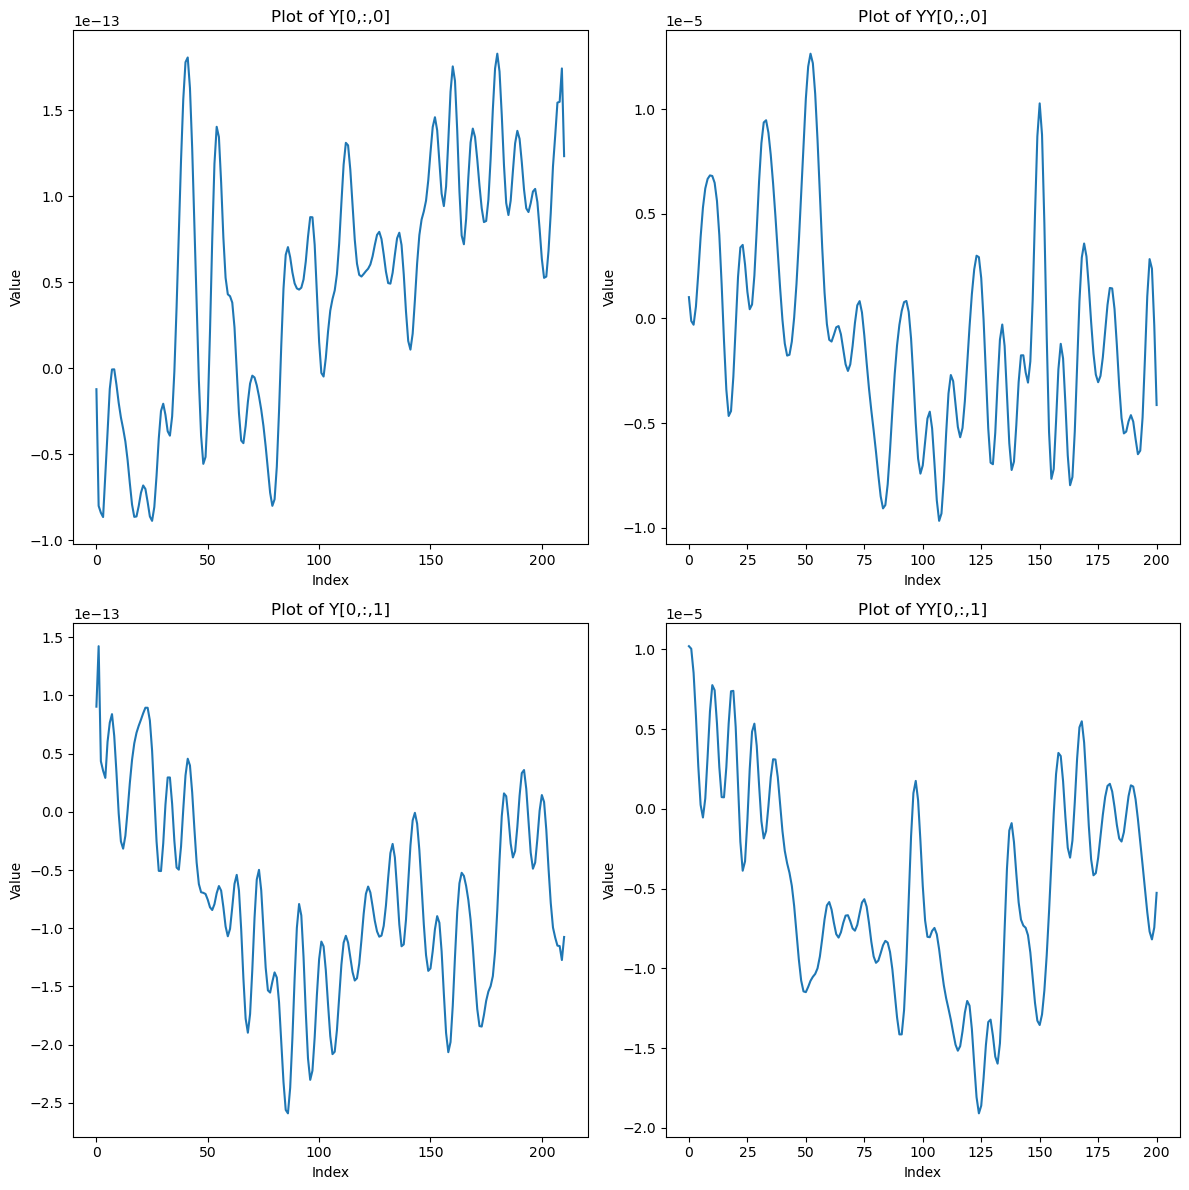

In [10]:
# Create subplots side by side
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

data = 3

# Plot Y[0,:,0] in the first subplot
axs[0, 0].plot(Y[0,:,0])
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Plot of Y[0,:,0]')

# Plot YY[0,:,0] in the second subplot
axs[0, 1].plot(YY[0,:,0])
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title('Plot of YY[0,:,0]')

# Plot Y[0,:,1] in the third subplot
axs[1, 0].plot(Y[0,:,data])
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title('Plot of Y[0,:,1]')

# Plot YY[0,:,1] in the fourth subplot
axs[1, 1].plot(YY[0,:,data])
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_title('Plot of YY[0,:,1]')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
print(np.shape(label))
print(label)

(273, 1)
[['MLC12'], ['MLC13'], ['MLC14'], ['MLC15'], ['MLC16'], ['MLC17'], ['MLC21'], ['MLC22'], ['MLC23'], ['MLC24'], ['MLC25'], ['MLC31'], ['MLC32'], ['MLC41'], ['MLC42'], ['MLC51'], ['MLC52'], ['MLC53'], ['MLC54'], ['MLC55'], ['MLC61'], ['MLC62'], ['MLC63'], ['MLF11'], ['MLF12'], ['MLF13'], ['MLF14'], ['MLF21'], ['MLF22'], ['MLF23'], ['MLF24'], ['MLF25'], ['MLF31'], ['MLF32'], ['MLF33'], ['MLF34'], ['MLF35'], ['MLF41'], ['MLF42'], ['MLF43'], ['MLF44'], ['MLF45'], ['MLF46'], ['MLF51'], ['MLF52'], ['MLF53'], ['MLF54'], ['MLF55'], ['MLF56'], ['MLF61'], ['MLF62'], ['MLF63'], ['MLF64'], ['MLF65'], ['MLF66'], ['MLF67'], ['MLO11'], ['MLO12'], ['MLO13'], ['MLO14'], ['MLO21'], ['MLO22'], ['MLO23'], ['MLO24'], ['MLO31'], ['MLO32'], ['MLO33'], ['MLO34'], ['MLO41'], ['MLO42'], ['MLO43'], ['MLO44'], ['MLO51'], ['MLO52'], ['MLO53'], ['MLP11'], ['MLP12'], ['MLP21'], ['MLP22'], ['MLP23'], ['MLP31'], ['MLP32'], ['MLP33'], ['MLP34'], ['MLP35'], ['MLP41'], ['MLP42'], ['MLP43'], ['MLP44'], ['MLP45'], 

the binned_phi's from ori data are from 0 to 7

In [12]:

phi = X * (180/numC);   # Presented orientation in degrees
print(phi)
if numC == 8:
    binned_phi = np.digitize(phi, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) )-1 # bins collapsing degrees by similarity
else:
    binned_phi = np.digitize(phi, bins = np.array([  0, 45, 90,  135 ]) )-1
print(binned_phi)
numF = Y.shape[0];
numT = Y.shape[1];
numN = Y.shape[2];

[157.5   0.  135.  157.5   0.   90.   22.5   0.   22.5  67.5  67.5  67.5
  67.5 112.5 135.    0.   45.   67.5 112.5  22.5 157.5  45.  112.5  22.5
   0.  157.5  90.  112.5   0.   67.5  67.5 135.  112.5  45.  135.  135.
 135.    0.  112.5  90.   90.   22.5 157.5  90.   67.5 157.5  90.    0.
 135.   22.5  22.5  90.   45.   90.   90.  112.5   0.   67.5 112.5 135.
 112.5  67.5  90.   45.  157.5  45.  157.5  45.   45.  135.  135.   45.
  22.5 135.    0.   45.   22.5 157.5  22.5   0.  135.  157.5   0.  157.5
 157.5 112.5  22.5  45.  112.5  90.   90.   22.5  67.5  45.  135.  112.5
  22.5  90.  157.5  90.  157.5   0.  112.5  22.5  90.   45.  112.5   0.
 135.   45.    0.    0.    0.  157.5 135.  112.5 112.5  45.   67.5 112.5
  45.   45.    0.  112.5  45.   67.5  22.5  67.5  22.5 135.   90.   90.
   0.   67.5  45.   45.  135.   67.5  45.  157.5 157.5   0.  112.5  90.
 135.   22.5  90.  157.5 135.  157.5   0.    0.  157.5  67.5  45.  157.5
 112.5  45.   67.5 157.5  45.   22.5 112.5   0.   22.5 112

Creating and saving dat

In [13]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
# binned_phi = (G-1)*(180/8)
# G = (G-1)*(180/4)
print(G.shape)
CONDS = np.unique(G);
nConds = CONDS.size
print(CONDS)
nfold = 2
# FoldsIdx = dt.CreateFolds(binned_phi, Y, nfold)
FoldsIdx = dt.CreateFolds(G, Y, nfold)

(760,)
[0 1 2 3 4 5 6 7]


In [14]:
dat = dict()
dat['X_train'] = G[ FoldsIdx[0]['train_index']]
dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['train_index']])
dat['phi_train'] = phi[ FoldsIdx[0]['train_index']]
dat['new_train'] = binned_phi[ FoldsIdx[0]['train_index']]

dat['X_test'] = G[ FoldsIdx[0]['test_index']]
dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['test_index']])
dat['phi_test'] = phi[ FoldsIdx[0]['test_index']]

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
(8, 380) (8, 380)


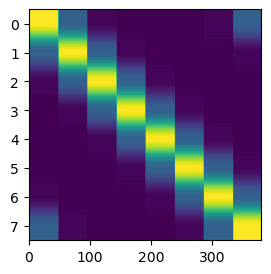

In [15]:
print(np.unique(dat['phi_train']))
design, sortedesign = dt.stim_features(dat['phi_train'], cfg_stim)
# design, sortedesign = dt.stim_features(dat['new_train'], cfg)
# design, sortedesign = dt.stim_features(binned_phi, cfg)
print(np.shape(design), np.shape(sortedesign))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto'
           # ,interpolation = 'none'
           )

# Part 1

Training encoding model

In [16]:
print(np.shape(design), np.shape(dat['Y_train']))

decoder = dt.train_encoder(design, dat['Y_train'], cfg_train)

print(np.shape(decoder))

(8, 380) (273, 380)
()


Testing the encoding model

In [17]:
print(np.shape(decoder), np.shape(dat['Y_test']))

Xhat = dt.test_encoder( decoder, dat['Y_test'], cfg_test)

print(np.shape(Xhat))

() (273, 380)
(8, 380)


__Preparing data for plotting results__

In [18]:
print(Xhat.shape)

(8, 380)


In [19]:
dat['X_test']

array([7, 0, 6, 7, 0, 4, 1, 0, 1, 3, 3, 3, 3, 5, 6, 0, 2, 3, 5, 1, 7, 2,
       5, 1, 0, 7, 4, 5, 0, 3, 3, 6, 5, 2, 6, 6, 6, 0, 5, 4, 4, 1, 7, 4,
       3, 7, 4, 0, 6, 1, 1, 4, 2, 4, 4, 5, 0, 3, 5, 6, 5, 3, 4, 2, 7, 2,
       7, 2, 2, 6, 6, 2, 1, 6, 0, 2, 1, 7, 1, 0, 6, 7, 0, 7, 7, 5, 1, 2,
       5, 4, 4, 1, 3, 2, 6, 5, 1, 4, 7, 4, 7, 0, 5, 1, 4, 2, 5, 0, 6, 2,
       0, 0, 0, 7, 6, 5, 5, 2, 3, 5, 2, 2, 0, 5, 2, 3, 1, 3, 1, 6, 4, 4,
       0, 3, 2, 2, 6, 3, 2, 7, 7, 0, 5, 4, 6, 1, 4, 7, 6, 7, 0, 0, 7, 3,
       2, 7, 5, 2, 3, 7, 2, 1, 5, 0, 1, 5, 1, 7, 6, 7, 3, 6, 3, 3, 3, 1,
       0, 4, 4, 5, 1, 4, 6, 4, 4, 1, 6, 6, 0, 4, 0, 4, 7, 7, 3, 6, 5, 5,
       3, 2, 1, 1, 3, 5, 6, 4, 4, 1, 1, 2, 5, 3, 0, 2, 4, 4, 6, 6, 5, 6,
       7, 3, 7, 3, 0, 1, 5, 0, 4, 0, 0, 1, 2, 7, 3, 2, 7, 3, 1, 5, 2, 2,
       6, 6, 1, 0, 2, 5, 3, 1, 6, 4, 3, 3, 2, 2, 5, 7, 4, 2, 7, 6, 5, 1,
       0, 5, 1, 3, 6, 6, 7, 4, 4, 6, 4, 0, 5, 7, 0, 7, 1, 5, 7, 2, 6, 5,
       2, 1, 3, 0, 6, 6, 6, 0, 7, 0, 5, 3, 4, 5, 6,

In [20]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, np.where(dat['X_test'] == (ic))[0]], axis = 1)


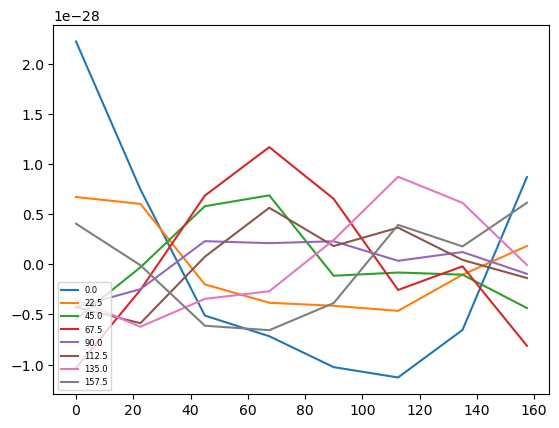

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the line chart
plt.plot(x_labels, m)
plt.legend(x_labels, loc=3, prop={'size': 6})

# Show the plot
plt.show()


In [22]:
stophere

NameError: name 'stophere' is not defined

# For all sel_t for EGG datasset

In [ ]:
numT

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(14, 15, figsize=(15, 28), sharex=True, sharey=True)

for sel_t in range(200):
    dat['X_train'] = G[FoldsIdx[0]['train_index']]
    dat['Y_train'] = np.squeeze(Y[:, sel_t, FoldsIdx[0]['train_index']])
    dat['phi_train'] = phi[FoldsIdx[0]['train_index']]
    dat['new_train'] = binned_phi[FoldsIdx[0]['train_index']]
    dat['X_test'] = G[FoldsIdx[0]['test_index']]
    dat['Y_test'] = np.squeeze(Y[:, sel_t, FoldsIdx[0]['test_index']])
    dat['phi_test'] = phi[FoldsIdx[0]['test_index']]
    design, sortedesign = dt.stim_features(dat['phi_train'], cfg_stim)
    decoder = dt.train_encoder(design, dat['Y_train'], cfg_train)
    Xhat = dt.test_encoder(decoder, dat['Y_test'], cfg_test)
    m = np.zeros((numC, numC))
    for ic in range(numC):
        m[:, ic] = np.mean(Xhat[:, np.where(dat['X_test'] == (ic + 1))[0]], axis=1)
    row = sel_t // 15
    col = sel_t % 15
    axs[row, col].plot(x_labels, m)
    # axs[row, col].legend(x_labels, loc=3, prop={'size': 6})
    axs[row, col].set_title(f'sel_t = {sel_t}')
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

mean_data = np.zeros((numC, len(x_labels)))
for sel_t in range(200):
    dat['X_train'] = G[FoldsIdx[0]['train_index']]
    dat['Y_train'] = np.squeeze(Y[:, sel_t, FoldsIdx[0]['train_index']])
    dat['phi_train'] = phi[FoldsIdx[0]['train_index']]
    dat['new_train'] = binned_phi[FoldsIdx[0]['train_index']]
    dat['X_test'] = G[FoldsIdx[0]['test_index']]
    dat['Y_test'] = np.squeeze(Y[:, sel_t, FoldsIdx[0]['test_index']])
    dat['phi_test'] = phi[FoldsIdx[0]['test_index']]
    design, sortedesign = dt.stim_features(dat['phi_train'], cfg_stim)
    decoder = dt.train_encoder(design, dat['Y_train'], cfg_train)
    Xhat = dt.test_encoder(decoder, dat['Y_test'], cfg_test)
    m = np.zeros((numC, numC))
    for ic in range(numC):
        m[:, ic] = np.mean(Xhat[:, np.where(dat['X_test'] == (ic + 1))[0]], axis=1)
    mean_data += m

mean_data /= 200  # Calculate the average over all iterations

for i in range(numC):
    ax.plot(x_labels, mean_data[i])

ax.legend(loc='best')
ax.set_xlabel('X Labels')
ax.set_ylabel('Mean')
ax.set_title('Mean of the Data')

plt.tight_layout()
plt.show()


Re-alligning predictions for trials with identical orientation

In [ ]:
Xhat_centered = 0*Xhat.copy()
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:,np.where(dat['X_test'] == (ic+1))] = np.roll(Xhat[:,np.where(dat['X_test'] == (ic+1))], -ic, axis = 0)

In [ ]:
m_centered = np.zeros((numC,numC))
for ic in range(numC):
   m_centered[:,ic] =  np.mean( Xhat_centered[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)

In [ ]:
print(m_centered.shape)

In [ ]:
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [ ]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

Getting mean orientation values for each stimulus bin

In [ ]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[np.where(dat['X_test'] == (ic+1))[0]] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

In [ ]:
print(m.shape)

In [ ]:
print(Xhat[0].shape)

In [ ]:
plt.plot(x_labels, Xhat)
plt.legend(x_labels, loc=3, prop={'size': 6})


In [ ]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
# ax[0].plot(x_labels, m_centered)
ax[0].plot(x_labels, m)

ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(dat['phi_test'], theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2))

In [ ]:
print(crossval)

__Preparing crossvalidation procedure__

In [ ]:
import DecToolbox as dt
from importlib import reload  # Python 3.4+
reload(dt)

In [ ]:
print(G.shape)

In [ ]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

In [ ]:
numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = kappa
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(phi, cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [ ]:
from DecToolbox import CV_encoder
cfg = dict()
cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
cfg['cfgD'] = {'demean' : 'traindata'}
Xhat = CV_encoder(design, Y, sel_t, cfg, FoldsIdx)

In [ ]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1)], axis = 1)

Re-alligning predictions for trials with identical orientation

In [ ]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1)] = np.roll(Xhat[:,G == (ic+1)], -ic, axis = 0)
    m_centered[:,ic] =  np.mean( Xhat_centered[:,  G == (ic+1)], axis = 1)

In [ ]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [ ]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

Getting mean orientation values for each stimulus bin

In [ ]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[G == (ic+1)] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(phi, theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


# Part 2

In [ ]:
part2 = False

if not part2: 
    print(br)


__Temporal dimension decoding__

In [ ]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
print(G)
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

In [ ]:
numC = 8 # how many channels to use

# print(phi)
cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(phi, cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [ ]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT])
# for it in range(numT):
for it in range(120, 200):
    print(it)
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)
    

In [ ]:
m = np.zeros((numC,numC, numT))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1),:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [ ]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:] = np.roll(Xhat[:,G == (ic+1),:], -ic, axis = 0)
    m_centered[:,ic, : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :], axis = 1)

In [ ]:
print(m_centered.shape)

In [ ]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_shiftedmean,aspect='auto',vmin = -1e-28, vmax = 1e-28, interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()
#ax.set_xtickslabels(time)
#ax.set_Yticklabels(x_centeredlabels.astype(str))


__Crossmodal temporal generalization decoding__

In [ ]:
import time as tic


In [ ]:
start = tic.time()
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT, numT])
print('numT', numT)
#for it in range(numT):
for it in range(numT):

    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it, :] = dt.CV_TG_encoder(design, Y, it, cfg, FoldsIdx)
end = tic.time()

In [ ]:
(end-start)/60

In [ ]:
m = np.zeros((numC,numC, numT, numT))
for ic in range(numC):
   m[:,ic, :, :] =  np.mean( Xhat[:, G == (ic+1),:,:], axis = 1)

print(m.shape)

In [ ]:
mean = np.zeros((numC,numC))

for i in range (numT):
    mean = mean + m[:,:,i,i]

mean = mean / numT
mean.shape

In [ ]:
plt.plot(x_labels, mean)
plt.legend(x_labels, loc=3, prop={'size': 6})

Re-alligning predictions for trials with identical orientation

In [ ]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:, :] = np.roll(Xhat[:,G == (ic+1),:, :], -ic, axis = 0)
    m_centered[:,ic, : , : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :, :], axis = 1)


Plotting diagonal values

In [ ]:
diagonal_vals =  m_centered[:,:,range(numT),range(numT)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(np.mean(diagonal_vals, axis = 1),aspect='auto',vmin = -1e-28, vmax = 1e-28, interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()


Correlation between actual and predicted orientation values

In [ ]:
r = np.zeros((numT, numT))

for it1 in range(numT):
    for it2 in range(numT):
        # Kernel to back project channel outputs to orientation space
        kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
        Z = kernel @ Xhat[:,:, it1, it2]

        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

        rs = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
        r[it1, it2] = np.abs(rs) * np.cos(np.angle(rs))
        r

In [ ]:
time_labels = [0, 0.2, 0.4, 0.6]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(r, aspect= 1, interpolation = None, vmin = -0.25, vmax = 0.25, origin = 'lower',extent=[time[0],time[-1],time[0],time[-1]])
plt.colorbar()
#ax.set_xticklabels(time_labels)
#ax.set_yticklabels(time_labels)

In [ ]:
def CV_encoder(design, Y, sel_t, cfg, FoldsIdx):

    numC = design.shape[0]
    numN = Y.shape[2]

    Xhat = np.zeros([numC,numN])
    Xhat_centered = 0*Xhat.copy()

    nfold = np.size(FoldsIdx)

    for ifold in range(nfold):
        # Output matrix
        dat = dict()
        dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['train_index']])
        idesign = design[:,FoldsIdx[ifold]['train_index']]
        dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['test_index']])

        if 'cfgE' not in cfg:
            cfgE = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        else:
            cfgE = cfg['cfgE']

        decoder = dt.train_encoder(idesign, dat['Y_train'], cfgE)

        if 'cfgD' not in cfg:
            cfgD = {'demean' : 'traindata'}
        else:
            cfgD = cfg['cfgD']


        Xhat[:,FoldsIdx[ifold]['test_index']] = dt.test_encoder( decoder, dat['Y_test'], cfgD) 
    
    return Xhat

Getting mean orientation values for each stimulus bin

# Plotting results

In [ ]:
# Creating dat containing test and train indexes
nfold = 2

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=nfold,shuffle=False)
CrossValIdx = [None] * nfold
i = 0
for train_index, test_index  in  skf.split(X = np.zeros(numN), y = X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    CrossValIdx[i] = { 'train_index': train_index, 'test_index': test_index}
    i += 1

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [ ]:

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [ ]:
# G[dat[0].astype(int)]

In [ ]:
dat = [np.array([])]*nfold

for iCond in range(nConds):
    # Find indexes
    indx = np.where(G == CONDS[iCond])[0]
    n_indx = indx.size 
    # Shuffle indexes
    indx = np.random.permutation(indx)
    # Distribute across dat
    nelemxfold = np.floor(indx.size/nfold)
    groupNumber = np.repeat(np.arange(0,nfold), nelemxfold)

    for iFold in range(nfold):
        dat[iFold] = np.append(dat[iFold], indx[np.where(groupNumber == iFold)])

 

In [ ]:
indx[np.where(groupNumber == iFold)]